In [ ]:
assert qiskit.__version__ == '1.4.1'    
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.primitives import Sampler, Estimator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city

# Deutsch-Jozsa Algorithm

## Balanced Algorithm

In [9]:
def balanced_3_qubit_oracle(qr:QuantumRegister, ancilla:QuantumCircuit) -> qiskit.circuit.Gate:

    qc = QuantumCircuit(qr, ancilla)

    qc.cx(0, ancilla)

    gate = qc.to_gate(label='Balanced Oracle')
    gate.name = 'Balanced Oracle'

    return gate

In [10]:
def DJ_balanced(n:int, init:list=None) -> QuantumCircuit:
    '''
    @param n: number of qubits
    @return: Deutsch-Josza algorithm circuit
    '''

    if init is not None:
        assert len(init) == n+1


    qr = QuantumRegister(n, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)

    oracle = balanced_3_qubit_oracle(qr, ancilla)

    if init is None:
        for i in range(n):
            qc.initialize([1, 0], qr[i])
        
        qc.initialize([0, 1], ancilla)

    if init is not None:
        for i in range(n):
            qc.initialize(init[i], qr[i], normalize=True)
        
        qc.initialize(init[n], ancilla, normalize=True)

    for i in range(n):
        qc.h(i)
    
    qc.h(ancilla)

    qc.barrier()

    # append the custom oracle
    qc.append(oracle,range(n+1))

    qc.barrier()

    for i in range(n):
        qc.h(i)
    
    qc.barrier()

    for i in range(n):
        qc.measure(i, i)

    return qc

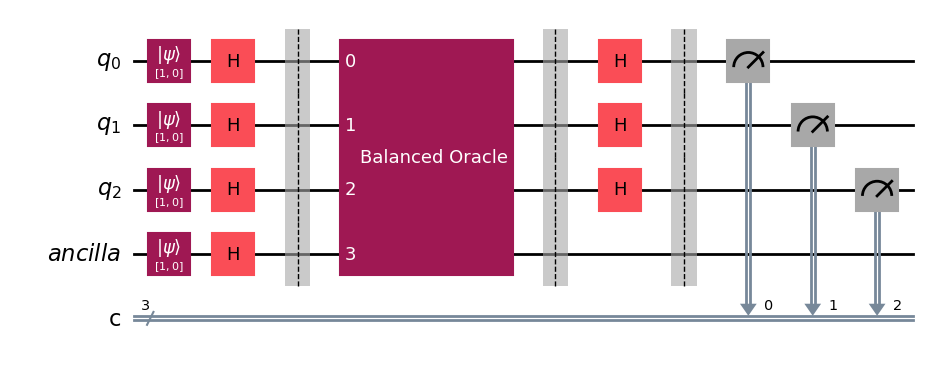

In [11]:
# Simulation
init = [[1, 0], [1, 0], [1, 0], [1, 0]]

qc = DJ_balanced(3, init=init)
qc.draw(output='mpl')

Single Input Simulation

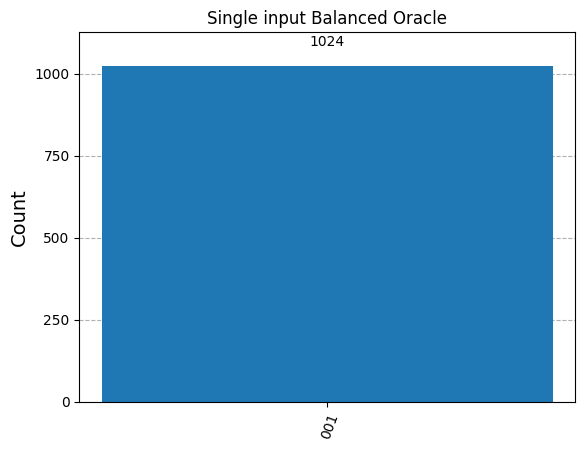

In [12]:
qc = DJ_balanced(3)

sim = AerSimulator(method='statevector')

qc = transpile(qc, sim)
result = sim.run(qc).result()

plot_histogram(result.get_counts(), title='Single input Balanced Oracle')

Multi input for Balance verification

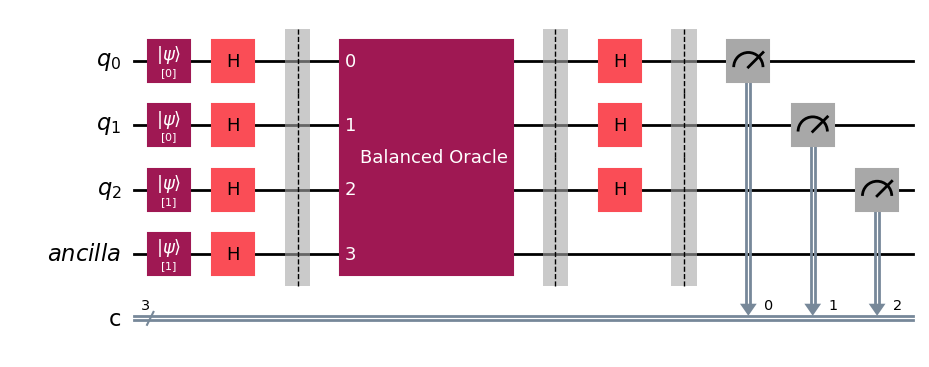

In [13]:
n = 4
inits = []
qcs = []

for i in range(2**n):
    init = bin(i)[2:].zfill(n)

    qr = QuantumRegister(n-1, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n-1, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)
    
    qc = DJ_balanced(n-1, init=init)

    qcs.append(qc)

qcs[3].draw(output='mpl')

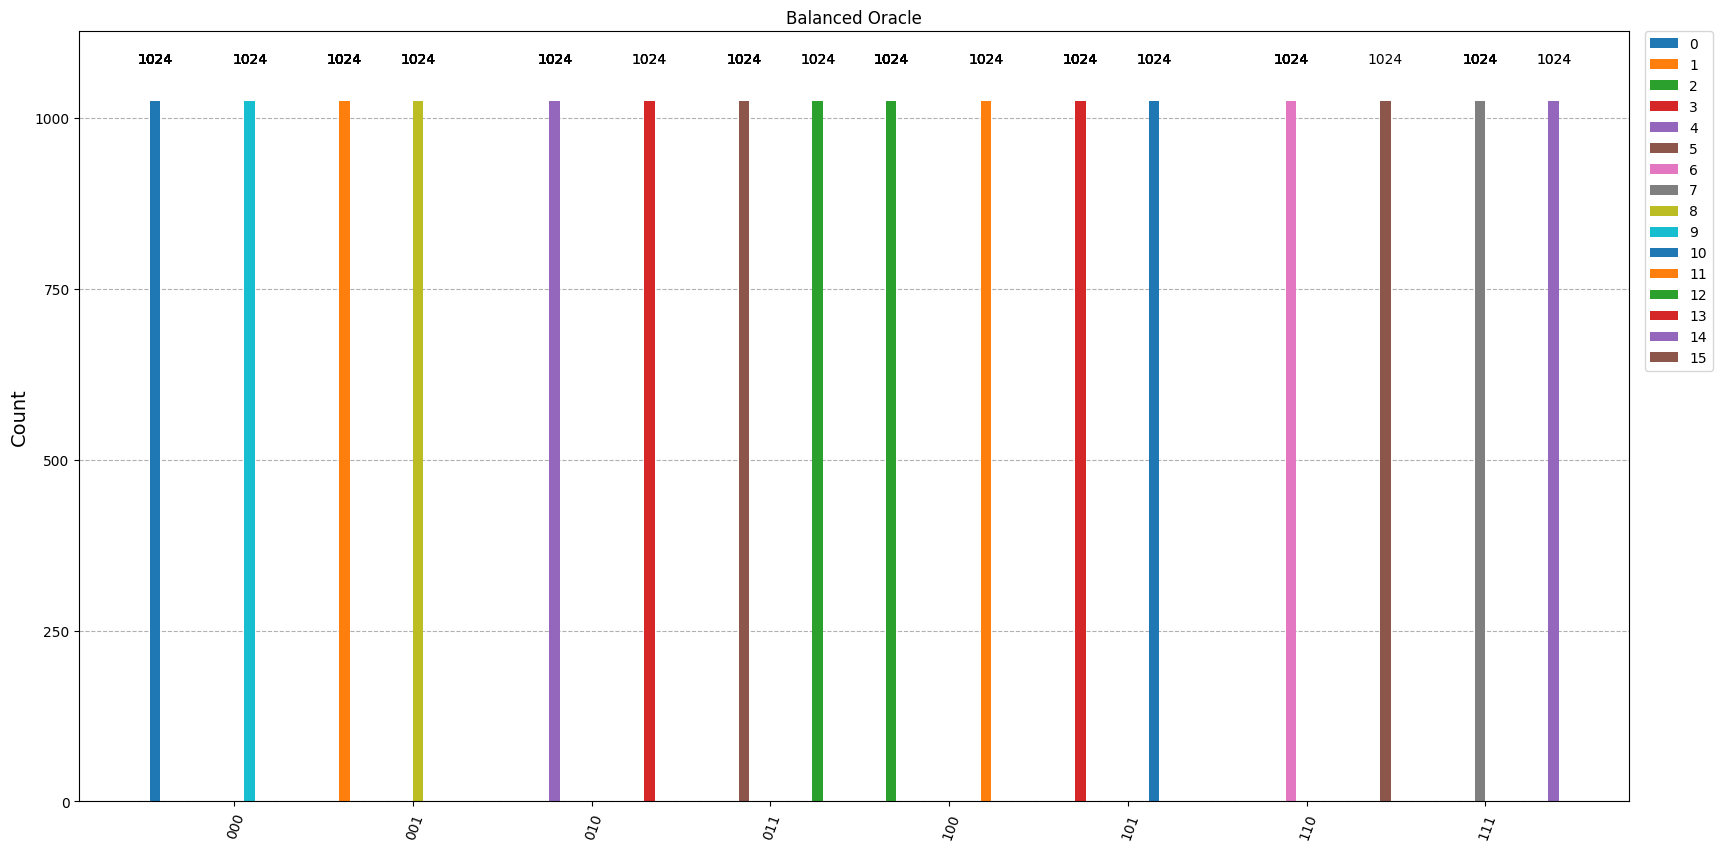

In [14]:
results = []
counts = []

for qc in qcs:
    sim = AerSimulator(method='statevector')
    qc = transpile(qc, sim)
    result = sim.run(qc).result()
    results.append(result)
    counts.append(result.get_counts())

plot_histogram(counts, legend=[f'{i}' for i in range(2**n)], title='Balanced Oracle', figsize=(20, 10))

## Simulation on Real Backend

In [15]:
simulation = True

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService('ibm_quantum')

leas_busy = service.least_busy(operational=True, min_num_qubits=5)

print(f'Least busy backend: {leas_busy}')

Least busy backend: <IBMBackend('ibm_sherbrooke')>


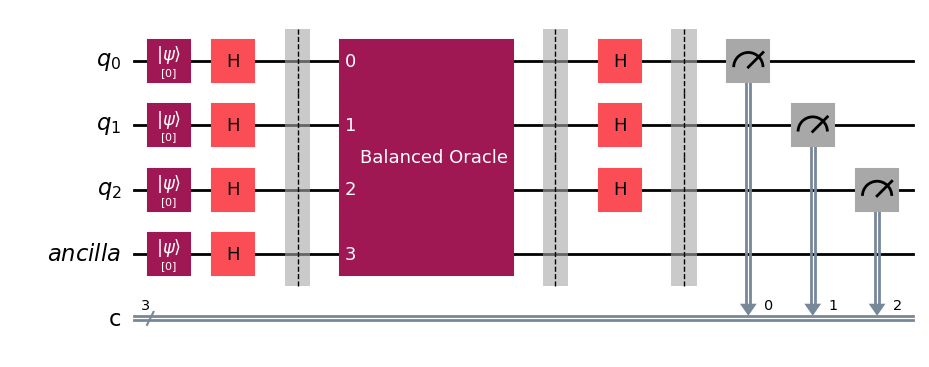

In [17]:
n = 4
inits = []
qcs = []

for i in range(2**n):
    init = bin(i)[2:].zfill(n)

    qr = QuantumRegister(n-1, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n-1, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)
    
    qc = DJ_balanced(n-1, init=init)

    qcs.append(qc)

qcs[0].draw(output='mpl')

### Transpile for real backend

In [18]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(optimization_level=3, backend=leas_busy)

qcs_trans = []
for qc in qcs:
    qcs_trans.append(pass_manager.run(qc))
# qcs_trans = pass_manager.run(qcs)

In [19]:
simulation = True

In [20]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

if not simulation:
    sampler = Sampler(mode=leas_busy)
    job = sampler.run(qcs_trans, shots=10000)


### Read results

In [21]:
job_id_0 = 'czghc2g7m0r0008vyn50'
job_id_1 = 'czgjtj2aejkg008cavgg'
job_id_2 = 'czgjyvkhrmy000842280'

counts_l = []
for jb in [job_id_0, job_id_1, job_id_2]:
    job = service.job(jb)
    result = job.result()
    single_counts = []
    for i in result:
        single_counts.append(i.data.c.get_counts())

    counts_l.append(single_counts)

## Results Balanced Oracle

In [22]:
labels = []
for i in range(2**n):
    labels.append(bin(i)[2:].zfill(n))
labels

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

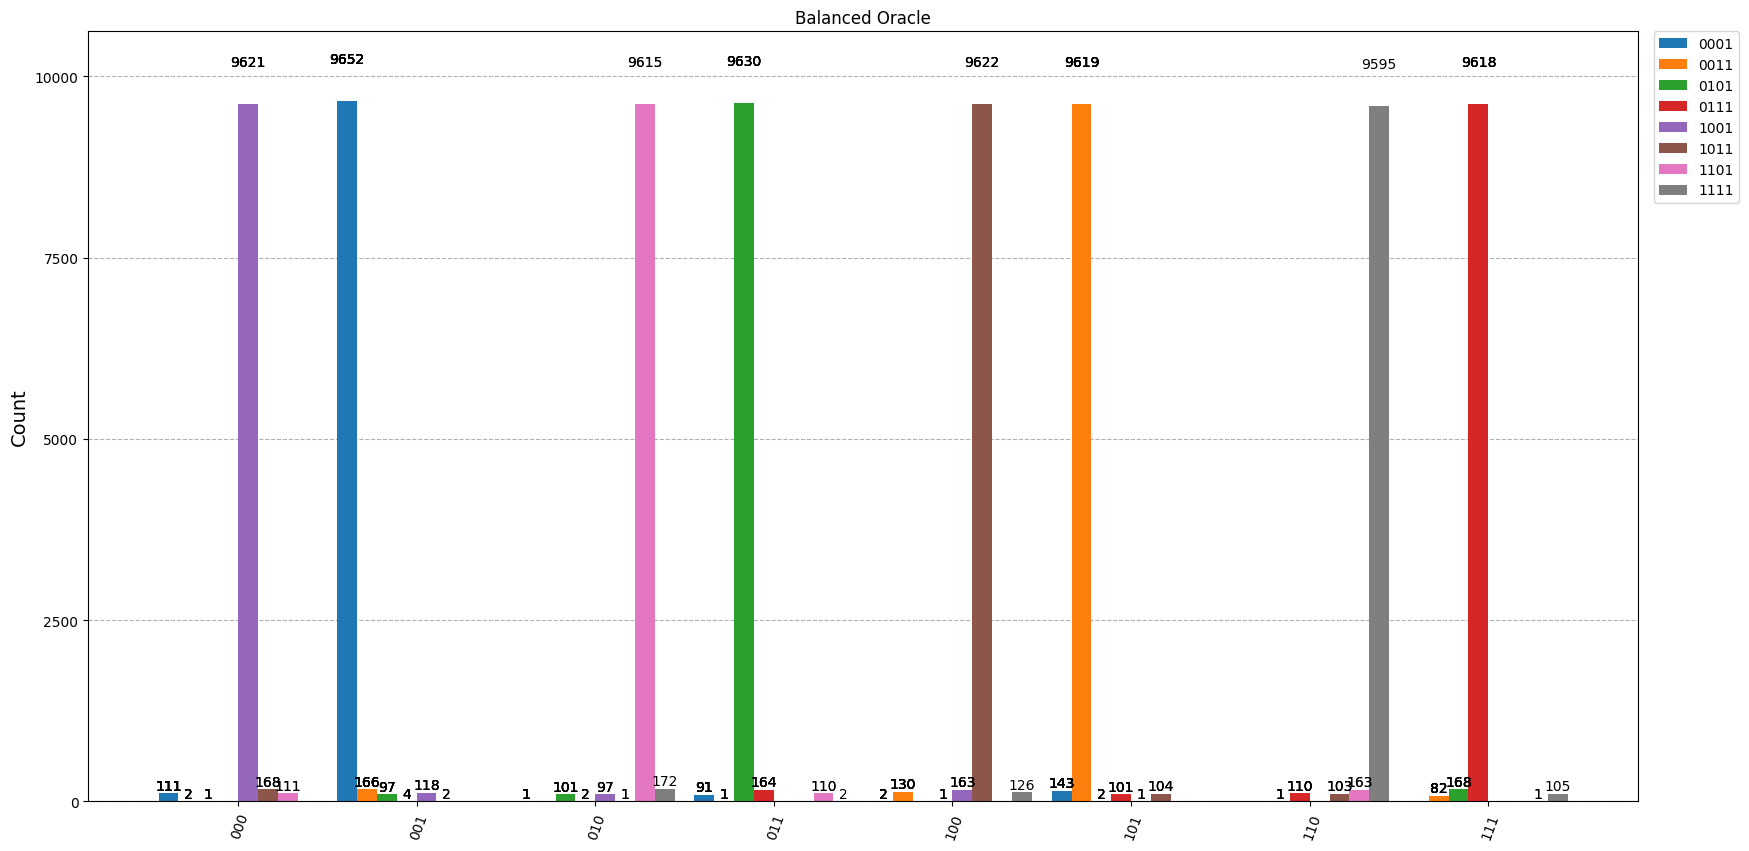

In [23]:
idxs = []
for i in range(2**n):
    if labels[i][3] == '1':
        idxs.append(i)

counts_new = []
labels_new = []
for i in range(2**n):
    if i in idxs:
        counts_new.append(counts_l[0][i])
        labels_new.append(labels[i])

plot_histogram(counts_new, legend=labels_new, title='Balanced Oracle', figsize=(20, 10))

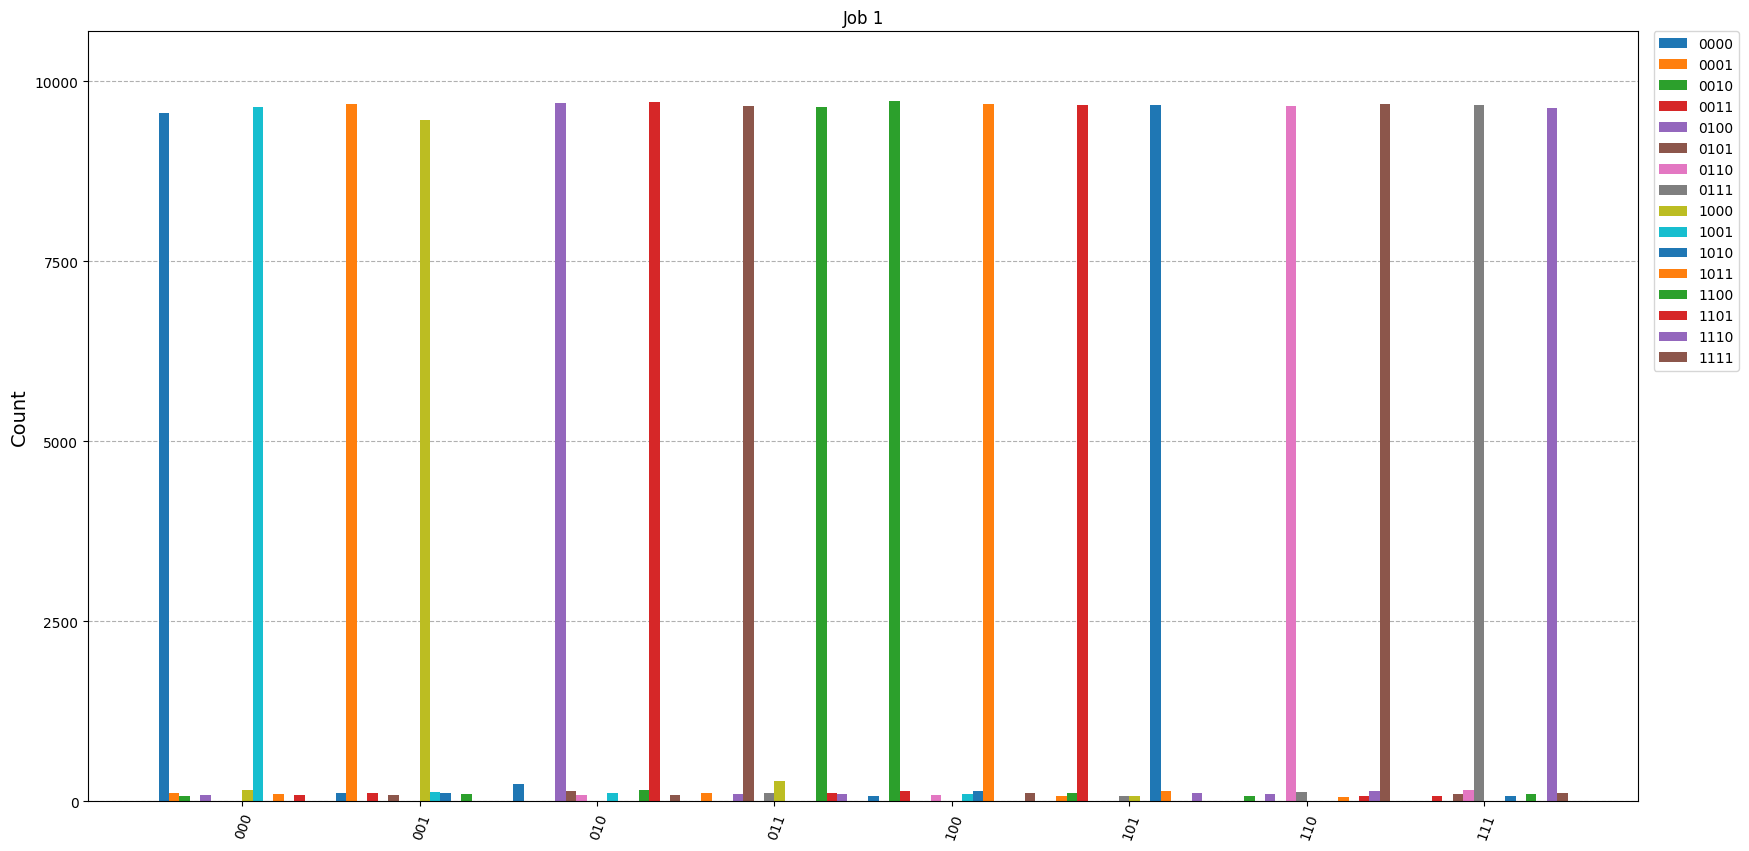

In [24]:
plot_histogram(counts_l[1], legend=labels, title='Job 1', figsize=(20, 10), bar_labels=False)

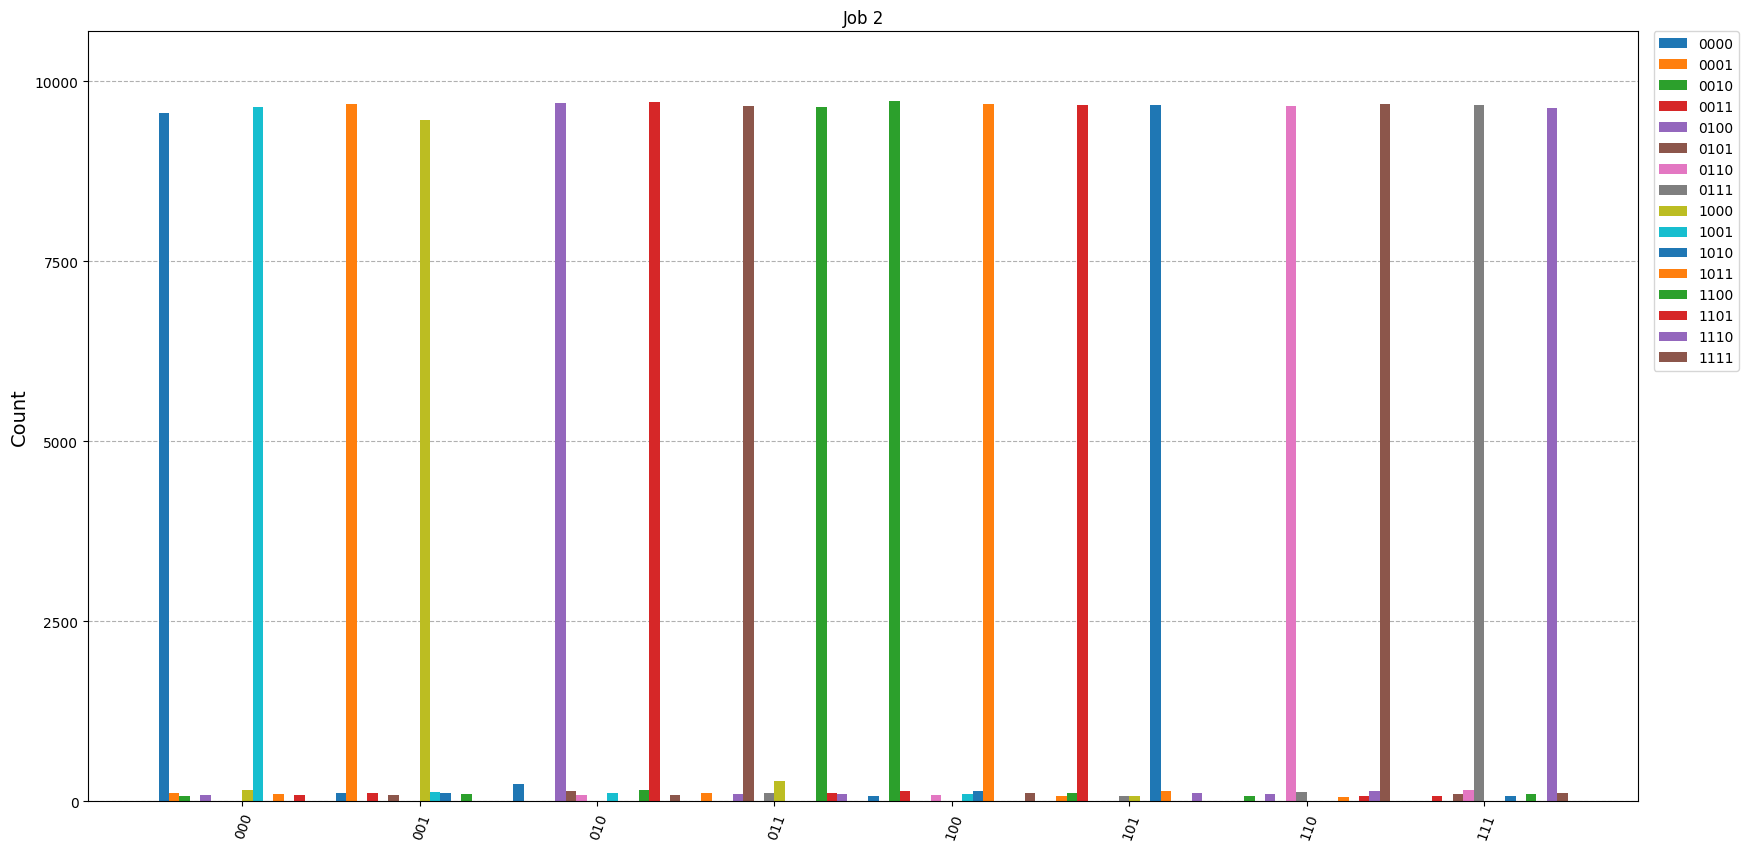

In [25]:
plot_histogram(counts_l[1], legend=labels, title='Job 2', figsize=(20, 10), bar_labels=False)

## Constant Oracle

In [26]:
def constant_n_qubit_oracle(qr:QuantumRegister, ancilla:QuantumCircuit) -> qiskit.circuit.Gate:

    qc = QuantumCircuit(qr, ancilla)

    for i in range(qr.size):
        qc.cx(i, ancilla)
    
    gate = qc.to_gate(label='Constant Oracle')
    gate.name = 'Constant Oracle'

    return gate

def DJ_constant(n:int, init:list=None) -> QuantumCircuit:

    qc = QuantumCircuit(n+1, n)

    oracle = constant_n_qubit_oracle(qc.qubits, qc.ancillas)

    if init is None:
        for i in range(n):
            qc.initialize([1, 0], i)

        qc.initialize([0, 1], n)

    if init is not None:
        for i in range(n):
            qc.initialize(init[i], i, normalize=True)
        
        qc.initialize(init[n], n, normalize=True)
    
    for i in range(n):
        qc.h(i)
    
    qc.h(n)

    qc.barrier()

    qc.append(oracle, range(n+1))

    qc.barrier()

    for i in range(n):
        qc.h(i)
    
    qc.barrier()

    for i in range(n):
        qc.measure(i, i)

    return qc

qc = DJ_constant(3)
qc.draw(output='mpl')

AttributeError: 'list' object has no attribute 'size'